In [248]:
import pandas as pd
import numpy as np 
import os
import GPy
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, DotProduct, ConstantKernel as C
from sklearn.ensemble import GradientBoostingRegressor

DATADIR = '../data'
TRAIN_SIZE = 0.9

In [262]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv')).values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
y = np.hstack([a2.reshape(-1,1), gibbs.reshape(-1,1)])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat, y, train_size=TRAIN_SIZE)

vt = VarianceThreshold(0)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

feat_scaler = StandardScaler()
X_train = feat_scaler.fit_transform(X_train)
X_test = feat_scaler.transform(X_test)

In [264]:
NFEAT = df_full_factorial_feat.shape[1]

In [265]:
kernel = RationalQuadratic(length_scale_bounds=(1e-3,1e3)) + DotProduct()

In [266]:
model = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=3, alpha=1e-4)

In [267]:
model.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0001, copy_X_train=True,
                         kernel=RationalQuadratic(alpha=1, length_scale=1) + DotProduct(sigma_0=1),
                         n_restarts_optimizer=3, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [268]:
prediction_test = model.predict(X_test)
prediction_train = model.predict(X_train)

In [269]:
def plot_parity(y_true, y_pred):
    fig, ax = plt.subplots()
    plt.scatter(y_true, y_pred)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75,  zorder=0)
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$\hat{y}$')
    fig.tight_layout()


 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


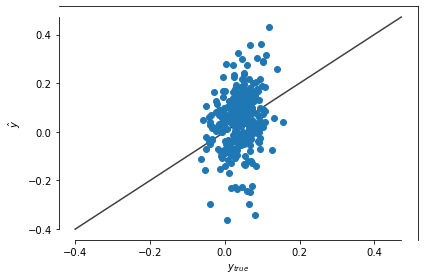

In [270]:
plot_parity(prediction_test[:,0], y_test[:,0])

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


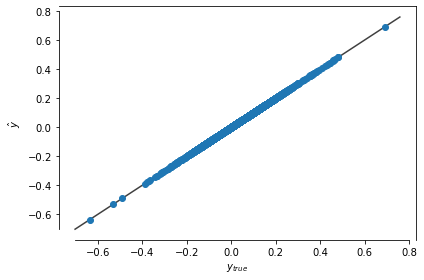

In [271]:
plot_parity(prediction_train[:,0], prediction_train[:,0])

## Get a baseline

### Gibbs

In [210]:
adaboost = GradientBoostingRegressor(n_estimators=500)

adaboost.fit(X_train, y_train[:,1])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [211]:
prediction_test = adaboost.predict(X_test)
prediction_train = adaboost.predict(X_train)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


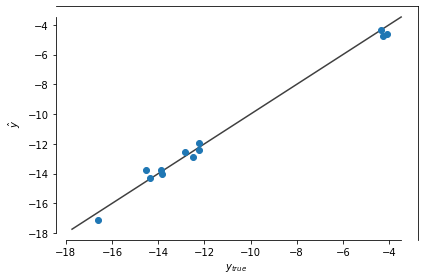

In [212]:
plot_parity(prediction_test, y_test[:,1])

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


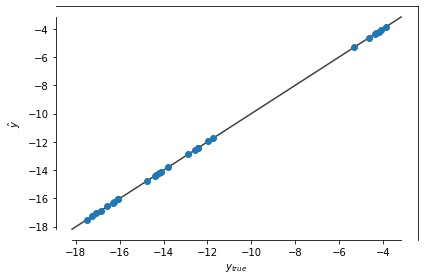

In [213]:
plot_parity(prediction_train, y_train[:,1])

## Virial

In [258]:
adaboost = GradientBoostingRegressor(n_estimators=500)

adaboost.fit(X_train, y_train[:,0])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [259]:
prediction_test = adaboost.predict(X_test)
prediction_train = adaboost.predict(X_train)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


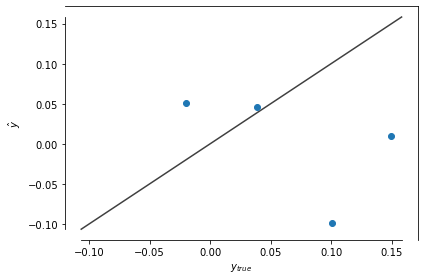

In [260]:
plot_parity(prediction_test, y_test[:,0])

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


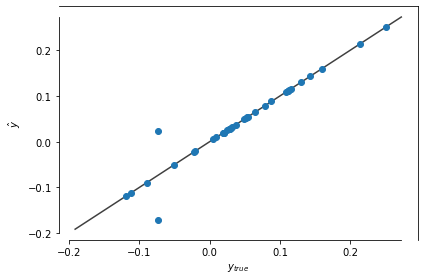

In [261]:
plot_parity(prediction_train, y_train[:,0])